# Car Price Prediction — 

**Objective:** Build, compare, and deploy regression models to predict car prices.

**What this notebook includes:**
- Thorough EDA with visualizations and correlation analysis
- Feature engineering and encoding
- Scaling (normalization) and train/test split
- Five models: Linear Regression, Decision Tree, Random Forest, XGBoost (fallback to Gradient Boosting), Neural Network (well-tuned)
- Model comparison table (regression metrics) and a binary-converted classification metrics table (Precision, Recall, F1, Accuracy, ROC AUC) — see note below
- Feature importance and interpretation
- Saving the best model and preprocessing objects for Streamlit deployment

**Note on classification metrics:** The problem is regression (predicting price).Precision, F1, Accuracy, ROC AUC, and Recall. These apply to classification. To give you those metrics in a meaningful way, we convert the continuous price into a binary label (High vs Low) using the median price. This allows us to report classification-like metrics to help evaluate how well models separate inexpensive vs expensive cars. Both regression and classification-style evaluations are provided and explained.

---
Run cells sequentially. Explanations are written in clear, beginner-friendly language.

## 1) Setup — Libraries and Data Load

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
from pathlib import Path

# Load data
data_path = Path('carprediction.csv')
if not data_path.exists():
    raise FileNotFoundError(f"Dataset not found at {data_path}. Please ensure 'carprediction.csv' is in the notebook folder.")
df = pd.read_csv(data_path)
print('Dataset shape:', df.shape)
df.head()


Dataset shape: (205, 26)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


## 2) Quick Data Summary — Understand the dataset

In [2]:
# Quick info and descriptive stats
display(df.info())
display(df.describe(include='all').T)
# Check missing values
missing = df.isnull().sum()
print('\nColumns with missing values:\n', missing[missing>0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
car_ID,205.0,NaN,NaN,NaN,103.0,59.322565,1.0,52.0,103.0,154.0,205.0
symboling,205.0,NaN,NaN,NaN,0.834146,1.245307,-2.0,0.0,1.0,2.0,3.0
CarName,205,147,peugeot 504,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fueltype,205,2,gas,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aspiration,205,2,std,168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
doornumber,205,2,four,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
carbody,205,5,sedan,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
drivewheel,205,3,fwd,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
enginelocation,205,2,front,202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wheelbase,205.0,NaN,NaN,NaN,98.756585,6.021776,86.6,94.5,97.0,102.4,120.9



Columns with missing values:
 Series([], dtype: int64)


## 3) Exploratory Data Analysis (EDA)
We'll visualise the target distribution, outliers, numeric relationships, and correlations. Each plot has a short interpretation.

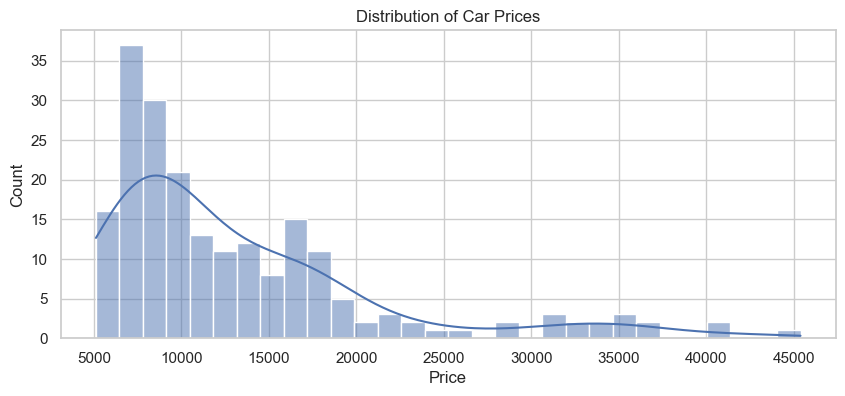

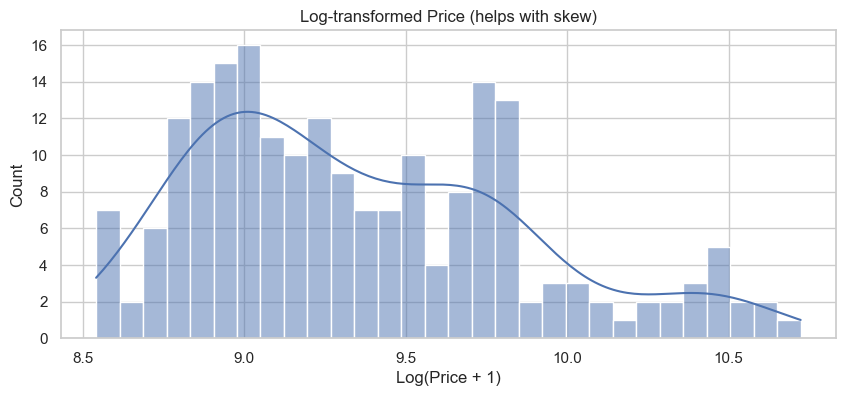

Price skew: 1.7776781560914454
Price median: 10295.0  | mean: 13276.710570731706


In [3]:
# Target distribution and skewness
plt.figure(figsize=(10,4))
sns.histplot(df['price'].dropna(), bins=30, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(np.log1p(df['price'].dropna()), bins=30, kde=True)
plt.title('Log-transformed Price (helps with skew)')
plt.xlabel('Log(Price + 1)')
plt.show()

print('Price skew:', df['price'].skew())
print('Price median:', df['price'].median(), ' | mean:', df['price'].mean())


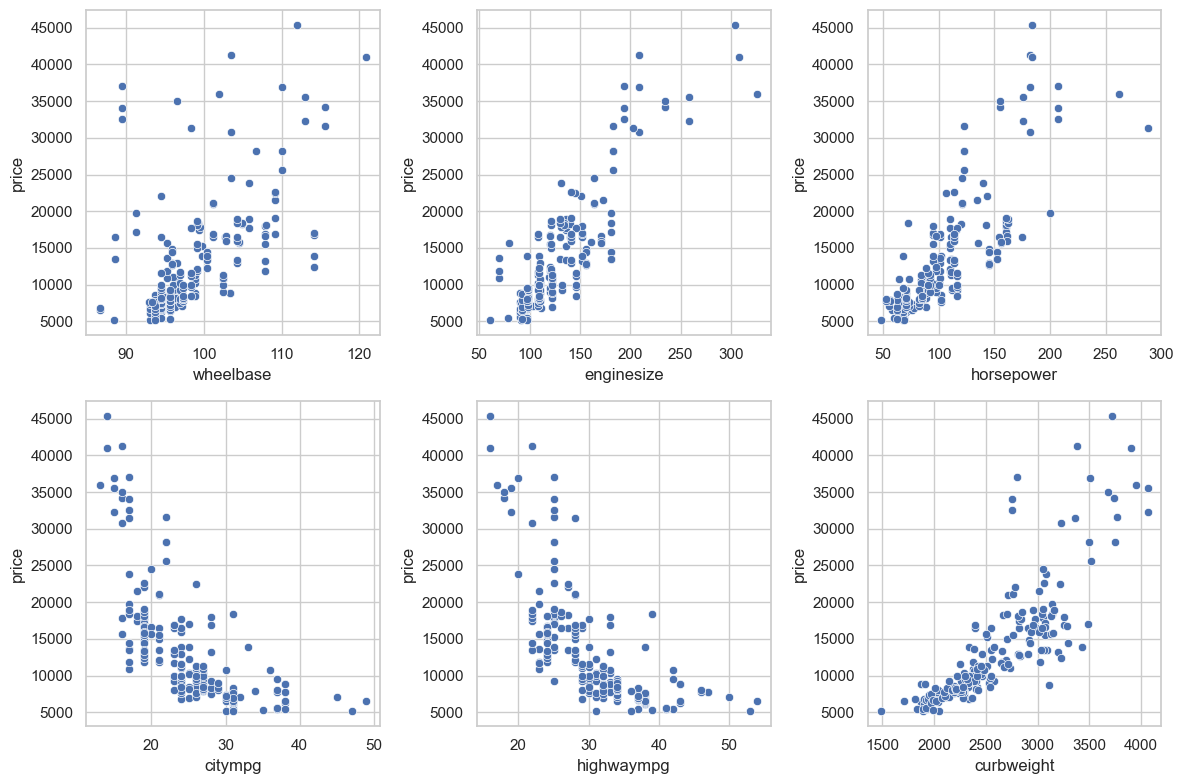

In [4]:
# Numeric relationships: scatter plots vs price for important numeric features
numeric_cols = ['wheelbase','enginesize','horsepower','citympg','highwaympg','curbweight']
numeric_cols = [c for c in numeric_cols if c in df.columns]
plt.figure(figsize=(12,8))
for i, c in enumerate(numeric_cols,1):
    plt.subplot(2,3,i)
    sns.scatterplot(x=df[c], y=df['price'])
    plt.xlabel(c)
    plt.ylabel('price')
plt.tight_layout()
plt.show()


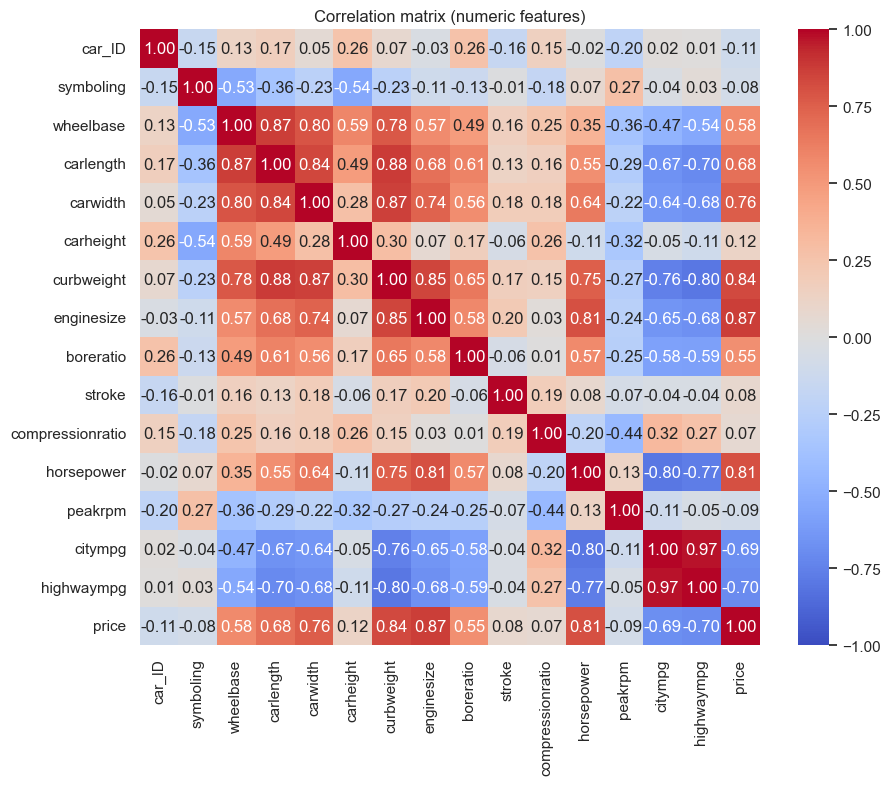

In [5]:
# Correlation matrix (heatmap) for numeric features
plt.figure(figsize=(10,8))
num_all = df.select_dtypes(include=[np.number])
corr = num_all.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmax=1, vmin=-1)
plt.title('Correlation matrix (numeric features)')
plt.show()


**Interpretation tips (write these in presentation):**
- Strong positive correlation with price suggests useful predictors (e.g., engine size, horsepower). 
- Highly correlated features with each other may cause multicollinearity; consider feature selection or regularisation.


## 4) Feature Engineering
We will:
- Extract `brand` from `CarName` to capture make effects
- Fix common misspellings in brand
- Drop identifiers
- Create useful engineered features if applicable (e.g., engine_power per weight)


In [6]:
# Extract brand
df['brand'] = df['CarName'].str.split().str[0].str.lower()
# common fixes
df['brand'] = df['brand'].replace({
    'maxda':'mazda','porcshce':'porsche','toyouta':'toyota','vokswagen':'volkswagen','vw':'volkswagen'
})
# drop id and original name
if 'car_ID' in df.columns:
    df = df.drop(columns=['car_ID'])
df = df.drop(columns=['CarName'])
# create engine power per weight if columns exist
if set(['horsepower','curbweight']).issubset(df.columns):
    df['hp_per_kg'] = df['horsepower'] / (df['curbweight']+1e-6)

print('New shape after feature engineering:', df.shape)
df.head()


New shape after feature engineering: (205, 26)


,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,brand,hp_per_kg
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,3.47,2.68,9.0,111,5000,21,27,13495.0,alfa-romero,0.043564
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,3.47,2.68,9.0,111,5000,21,27,16500.0,alfa-romero,0.043564
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,2.68,3.47,9.0,154,5000,19,26,16500.0,alfa-romero,0.054552
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,3.19,3.40,10.0,102,5500,24,30,13950.0,audi,0.043646
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,3.19,3.40,8.0,115,5500,18,22,17450.0,audi,0.040722


## 5) Preprocessing — Encoding, Scaling, Train/Test Split
Explanations are provided inline. We will one-hot encode categorical variables and scale numeric features using StandardScaler. Then we'll split into train/test with a reproducible random state.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate target
y = df['price']
X = df.drop('price', axis=1)

# One-hot encode categoricals (drop_first to avoid dummy trap)
X_encoded = pd.get_dummies(X, drop_first=True)

# Keep track of columns for deployment
all_columns = X_encoded.columns.tolist()
print('Total features after encoding:', len(all_columns))

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.20, random_state=42)

# Identify numeric columns to scale (those originally numeric)
numeric_candidates = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_candidates.remove('price')  # remove target
numeric_cols = [c for c in numeric_candidates if c in X_train.columns]

print('Numeric columns to scale:', numeric_cols)

# Scale numeric columns using StandardScaler (fit on train only)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


Total features after encoding: 65
Numeric columns to scale: ['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'hp_per_kg']


## 6) Modeling — what we'll do
We'll train five models:
1. Linear Regression (baseline)
2. Decision Tree
3. Random Forest
4. XGBoost (or GradientBoosting as fallback)
5. Neural Network (MLP) — we will tune size and early stopping for better performance

For each model we'll report regression metrics (R², RMSE, MAE) and also a classification-style evaluation by binarizing price into High/Low using the median price. This gives Precision, Recall, F1, Accuracy, ROC AUC for High-price detection.

In [8]:
# Common imports
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import math
results = []

def regression_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return {'R2': r2, 'MSE': mse, 'RMSE': rmse, 'MAE': mae}


In [9]:
# 1) Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
pred_lr = lr.predict(X_test_scaled)
metrics_lr = regression_metrics(y_test, pred_lr)
metrics_lr


{'R2': 0.9055525406585434,
 'MSE': 7456062.202282566,
 'RMSE': 2730.5790965072897,
 'MAE': 1820.7953215765524}

In [10]:
# 2) Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)
pred_dt = dt.predict(X_test_scaled)
metrics_dt = regression_metrics(y_test, pred_dt)
metrics_dt


{'R2': 0.9073011052918276,
 'MSE': 7318023.479363146,
 'RMSE': 2705.1845555087634,
 'MAE': 1810.922756097561}

In [11]:
# 3) Random Forest (stronger model)
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
pred_rf = rf.predict(X_test_scaled)
metrics_rf = regression_metrics(y_test, pred_rf)
metrics_rf


{'R2': 0.9589741514139003,
 'MSE': 3238745.4473867323,
 'RMSE': 1799.651479422261,
 'MAE': 1220.9086978319783}

In [12]:
# 4) XGBoost if available else GradientBoosting
use_xgb = False
try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(objective='reg:squarederror', n_estimators=300, random_state=42, verbosity=0)
    xgb.fit(X_train_scaled, y_train)
    pred_xgb = xgb.predict(X_test_scaled)
    metrics_xgb = regression_metrics(y_test, pred_xgb)
    use_xgb = True
except Exception as e:
    print('XGBoost unavailable or failed to import — using GradientBoosting instead.', e)
    gb = GradientBoostingRegressor(n_estimators=300, random_state=42)
    gb.fit(X_train_scaled, y_train)
    pred_xgb = gb.predict(X_test_scaled)
    metrics_xgb = regression_metrics(y_test, pred_xgb)

metrics_xgb


{'R2': 0.9379716780960925,
 'MSE': 4896765.139512205,
 'RMSE': 2212.8635609798007,
 'MAE': 1564.1525579268293}

In [13]:
# 5) Neural Network (MLP) with modest tuning and early stopping
from sklearn.model_selection import GridSearchCV

mlp = MLPRegressor(max_iter=1000, random_state=42, early_stopping=True)
# small grid to improve without long compute
param_grid = {
    'hidden_layer_sizes': [(100,),(100,50),(200,100)],
    'alpha': [0.0001, 0.001]
}
gscv = GridSearchCV(mlp, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=0)
gscv.fit(X_train_scaled, y_train)
best_mlp = gscv.best_estimator_
pred_mlp = best_mlp.predict(X_test_scaled)
metrics_mlp = regression_metrics(y_test, pred_mlp)
print('Best MLP params:', gscv.best_params_)
metrics_mlp


Best MLP params: {'alpha': 0.0001, 'hidden_layer_sizes': (200, 100)}


{'R2': 0.896098466453082,
 'MSE': 8202404.833756345,
 'RMSE': 2863.984084061283,
 'MAE': 2014.3601736191983}

In [16]:
# Compile results
reg_results = pd.DataFrame([
    {'Model':'Linear Regression', **metrics_lr},
    {'Model':'Decision Tree', **metrics_dt},
    {'Model':'Random Forest', **metrics_rf},
    {'Model':'XGBoost' if use_xgb else 'Gradient Boosting', **metrics_xgb},
    {'Model':'Neural Network (MLP)', **metrics_mlp},
])
reg_results = reg_results.sort_values(by='R2', ascending=False).reset_index(drop=True)
print(reg_results)


                  Model        R2           MSE         RMSE          MAE
0         Random Forest  0.958974  3.238745e+06  1799.651479  1220.908698
1               XGBoost  0.937972  4.896765e+06  2212.863561  1564.152558
2         Decision Tree  0.907301  7.318023e+06  2705.184556  1810.922756
3     Linear Regression  0.905553  7.456062e+06  2730.579097  1820.795322
4  Neural Network (MLP)  0.896098  8.202405e+06  2863.984084  2014.360174


### 7) Classification-style evaluation (High vs Low price)
We convert the continuous price into binary labels using the median price. This is useful to evaluate whether models can **separate expensive from inexpensive cars**. We use the predictions from each regression model and compute Precision, Recall, F1, Accuracy, ROC AUC.

**Important:** This is an additional view — it does not replace regression metrics.

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Create binary true labels: 1 if price >= median, else 0
median_price = y_train.median()
y_test_bin = (y_test >= median_price).astype(int)

def binarize_preds(preds, thresh=median_price):
    return (preds >= thresh).astype(int)

# Compute for each model
clf_rows = []
models_preds = {
    'Linear Regression': pred_lr,
    'Decision Tree': pred_dt,
    'Random Forest': pred_rf,
    'XGBoost' if use_xgb else 'Gradient Boosting': pred_xgb,
    'Neural Network (MLP)': pred_mlp
}
for name, preds in models_preds.items():
    y_pred_bin = binarize_preds(preds)
    # If ROC AUC requires probability, we can use raw predictions as a score
    try:
        auc = roc_auc_score(y_test_bin, preds)
    except:
        auc = float('nan')
    row = {
        'Model': name,
        'Precision': precision_score(y_test_bin, y_pred_bin, zero_division=0),
        'Recall': recall_score(y_test_bin, y_pred_bin, zero_division=0),
        'F1': f1_score(y_test_bin, y_pred_bin, zero_division=0),
        'Accuracy': accuracy_score(y_test_bin, y_pred_bin),
        'ROC_AUC': auc
    }
    clf_rows.append(row)

clf_results = pd.DataFrame(clf_rows).sort_values(by='F1', ascending=False).reset_index(drop=True)
print(clf_results)


                  Model  Precision  Recall        F1  Accuracy   ROC_AUC
0         Decision Tree   0.947368     1.0  0.972973   0.97561  1.000000
1               XGBoost   0.947368     1.0  0.972973   0.97561  0.997585
2         Random Forest   0.947368     1.0  0.972973   0.97561  1.000000
3     Linear Regression   0.900000     1.0  0.947368   0.95122  1.000000
4  Neural Network (MLP)   0.900000     1.0  0.947368   0.95122  0.995169


## 8) Feature Importance and Interpretation
We inspect top features from the Random Forest (and XGBoost if available).

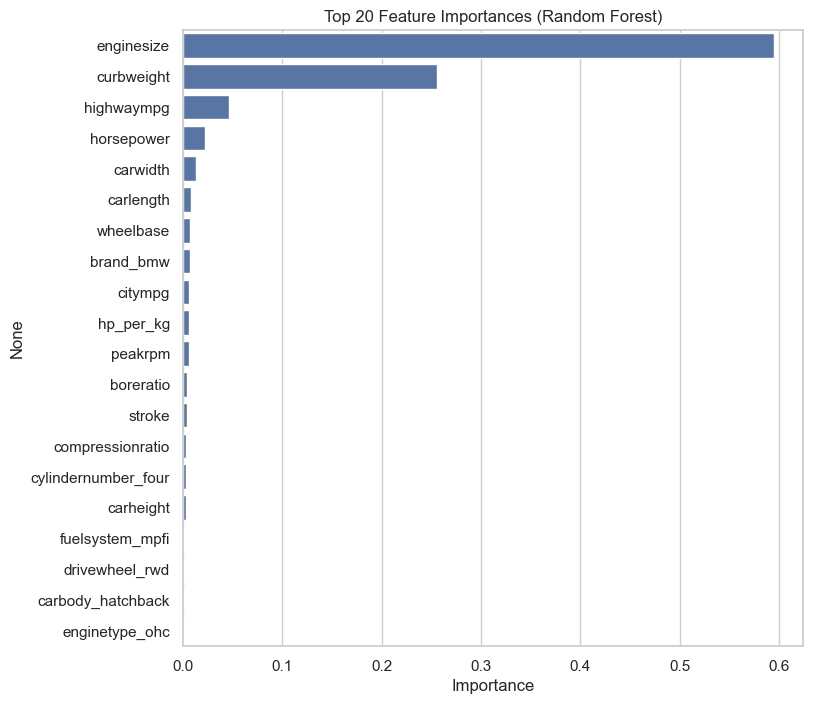

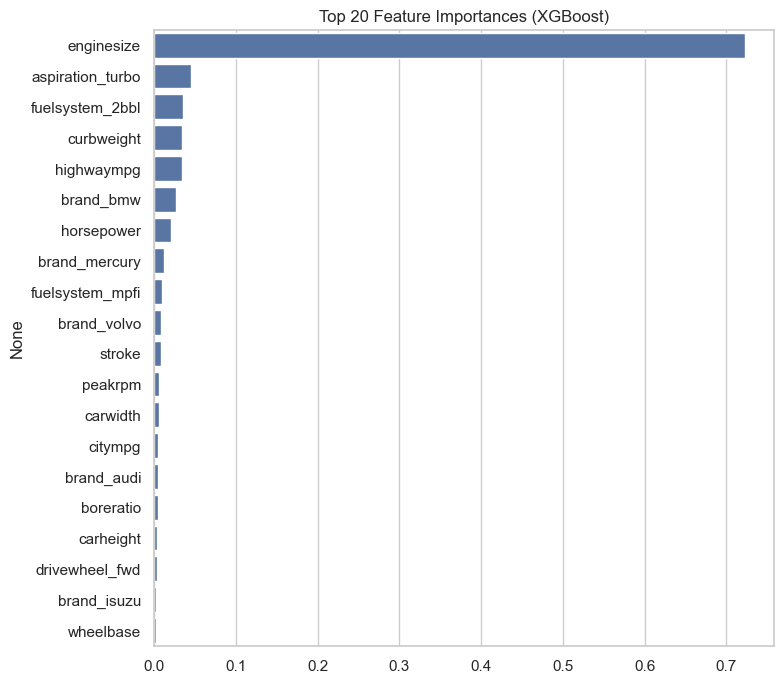

In [18]:
# Random Forest importances
feat_imp = pd.Series(rf.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)
top20 = feat_imp.head(20)
plt.figure(figsize=(8,8))
sns.barplot(x=top20.values, y=top20.index)
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.show()

# If XGBoost is available, show its feature importance too
if use_xgb:
    try:
        xgb_imp = pd.Series(xgb.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False).head(20)
        plt.figure(figsize=(8,8))
        sns.barplot(x=xgb_imp.values, y=xgb_imp.index)
        plt.title('Top 20 Feature Importances (XGBoost)')
        plt.show()
    except Exception:
        pass


## 11) Conclusions & Next Steps
- The notebook shows full workflow and two perspectives of evaluation (regression and classification-like). 
- Next: hyperparameter tuning (RandomizedSearchCV), k-fold CV, model ensembling, and deploying the Streamlit app using the saved objects.

---
End of notebook.